In [1]:
# library
# standard library
import os
# third-party library
from scipy.io import loadmat
import numpy as np
import torch
import torch.nn as nn
#import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
#torch.manual_seed(1)    # reproducible
from glob import glob
import shutil
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time

In [2]:
# Hyper Parameters
EPOCH = 10               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.01              # learning rate

In [3]:
tr_set = "./SVHN/train_32x32.mat"
te_set = "./SVHN/test_32x32.mat"

data = loadmat(tr_set)
te_data = loadmat(te_set)

X_tr, y_tr = data['X'], data['y']
X_te, y_te = te_data['X'], te_data['y']

X_tr, y_tr = X_tr.transpose((3,0,1,2)), y_tr[:,0]
X_te, y_te = X_te.transpose((3,0,1,2)), y_te[:,0]

# convert RGB to grayscale
def rgb2gray(img_data):
    return np.expand_dims(np.dot(img_data, [0.3, 0.6, 0.1]), axis=3)

X_tr_gr = rgb2gray(X_tr).astype(np.float32) # converts gray training set to float values
X_te_gr = rgb2gray(X_te).astype(np.float32)

In [4]:
X_tr = X_tr_gr.squeeze() # replace original training set
X_te = X_te_gr.squeeze()
y_te = y_te.squeeze() % 10
y_tr = y_tr.squeeze() % 10
print( X_tr.shape)
print(y_te.shape)

(73257, 32, 32)
(26032,)


In [5]:
y_tr[50:60]

array([9, 6, 0, 1, 2, 4, 5, 6, 5, 2], dtype=uint8)

In [6]:
y_tr[50:60] % 10

array([9, 6, 0, 1, 2, 4, 5, 6, 5, 2], dtype=uint8)

In [7]:
train_data = torch.tensor(X_tr)/255
train_labels = torch.tensor(y_tr)
test_data = torch.tensor(X_te)/255
test_labels = torch.tensor(y_te)

In [8]:
train_data[1]

tensor([[0.3008, 0.2988, 0.2961,  ..., 0.3165, 0.3110, 0.3129],
        [0.3051, 0.2945, 0.2725,  ..., 0.3227, 0.3169, 0.3204],
        [0.3000, 0.2957, 0.2106,  ..., 0.3306, 0.3247, 0.3204],
        ...,
        [0.3765, 0.3663, 0.3592,  ..., 0.4008, 0.3941, 0.3859],
        [0.3969, 0.4004, 0.3976,  ..., 0.3996, 0.3976, 0.3882],
        [0.4027, 0.4024, 0.4075,  ..., 0.4098, 0.4016, 0.3831]])

In [9]:
test_data[1]

tensor([[0.5459, 0.5455, 0.5427,  ..., 0.5153, 0.5212, 0.5239],
        [0.5733, 0.5690, 0.5675,  ..., 0.5357, 0.5322, 0.5314],
        [0.6035, 0.5992, 0.5988,  ..., 0.5686, 0.5549, 0.5475],
        ...,
        [0.6200, 0.6004, 0.5792,  ..., 0.3871, 0.3984, 0.4322],
        [0.5847, 0.5533, 0.5204,  ..., 0.3925, 0.4231, 0.4659],
        [0.5573, 0.5220, 0.4816,  ..., 0.4259, 0.4647, 0.5118]])

In [10]:
class Train_dataset(Dataset):
    def __init__(self,data,label):
        self.train_data = data
        self.train_labels = label
    
    def __len__(self):
        return len(self.train_data)
    
    def __getitem__(self,idx):
        return self.train_data[idx],self.train_labels[idx]

In [11]:
class Test_dataset(Dataset):
    def __init__(self,data,label):
        self.test_data = data
        self.test_labels = label
    
    def __len__(self):
        return len(self.test_data)
    
    def __getitem__(self,idx):
        return self.test_data[idx],self.test_labels[idx]

In [12]:
train_data = Train_dataset(train_data,train_labels)
test_data = Test_dataset(test_data,test_labels)

In [13]:
print(train_data.train_data.size()) 

torch.Size([73257, 32, 32])


In [14]:
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

In [15]:
# pick 2000 samples to speed up testing
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]   # shape from (2000, 32, 32) to (2000, 1, 32, 32), value in range(0,1)
test_y = test_data.test_labels[:2000]

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 32, 32)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 32, 32)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 16, 16)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 16, 16)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 16, 16)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 8, 8)
        )
        self.out = nn.Linear(32 * 8 * 8, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


In [17]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all logistic parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [18]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

Epoch:  0 | train loss: 2.3041 | test accuracy: 0.12


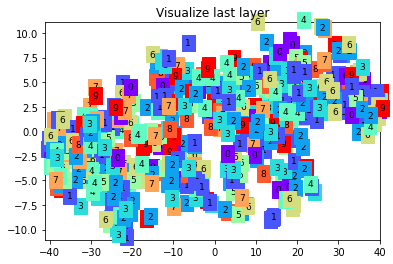

Epoch:  1 | train loss: 2.1963 | test accuracy: 0.19


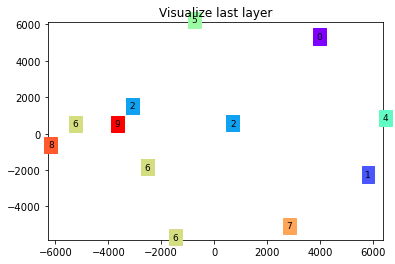

Epoch:  2 | train loss: 2.2327 | test accuracy: 0.19


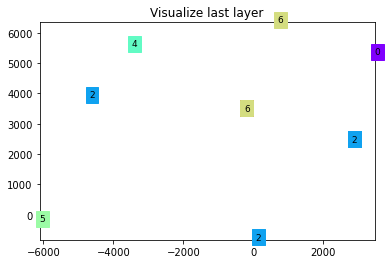

Epoch:  3 | train loss: 2.2861 | test accuracy: 0.19


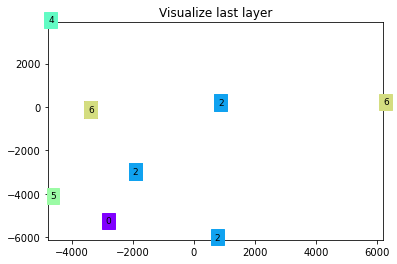

Epoch:  4 | train loss: 2.3372 | test accuracy: 0.19


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


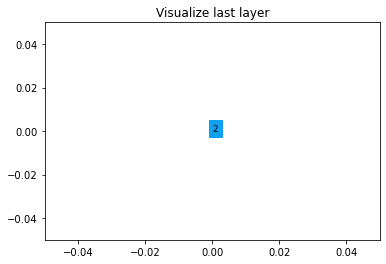

Epoch:  5 | train loss: 2.3104 | test accuracy: 0.19


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


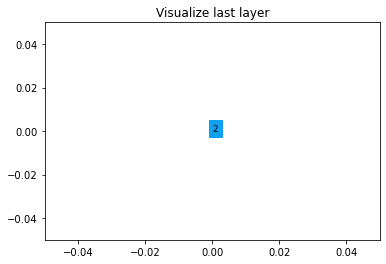

Epoch:  6 | train loss: 2.2786 | test accuracy: 0.19


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


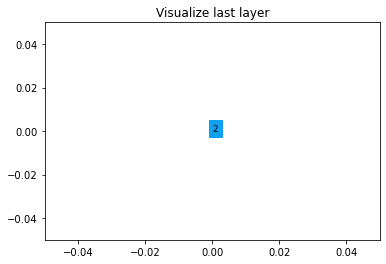

Epoch:  7 | train loss: 2.2162 | test accuracy: 0.19


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


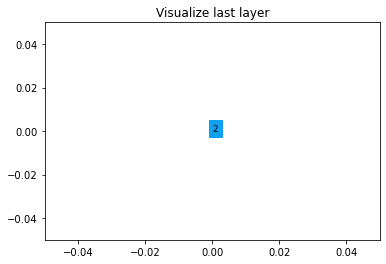

Epoch:  8 | train loss: 2.2468 | test accuracy: 0.19


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


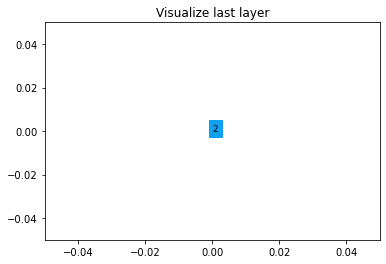

Epoch:  9 | train loss: 2.2757 | test accuracy: 0.19


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
<ipython-input-18-252c15ddcdea>:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


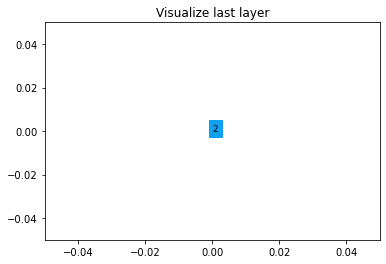

In [19]:
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        
        b_y=b_y.long()
        b_x=torch.unsqueeze(b_x, dim=1)
        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 60000 == 0:

            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

In [20]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[1 1 1 1 1 1 1 1 1 1] prediction number
[5 2 1 0 6 1 9 1 1 8] real number
